In [ ]:
from polimi.utils.tf_models.utils.build_sequences import build_history_seq, build_sequences_seq_iterator, N_CATEGORY, N_SENTIMENT_LABEL, N_SUBCATEGORY, N_TOPICS, N_HOUR_GROUP, N_WEEKDAY
from polimi.utils.tf_models import TemporalHistorySequenceModel
import joblib
import tensorflow as tf

model = TemporalHistorySequenceModel(
    seq_embedding_dims={
        # adding one dim more to cover missings, where needed
        'input_topics': (N_TOPICS + 1, 10, True),
        'input_subcategory': (N_SUBCATEGORY + 1, 10, True),
        'input_category': (N_CATEGORY + 1, 10, False),
        'input_weekday': (N_WEEKDAY, 3, False),
        'input_hour_group': (N_HOUR_GROUP, 3, False),
        'input_sentiment_label': (N_SENTIMENT_LABEL + 1, 2, False)
    },
    seq_numerical_features=['scroll_percentage', 'read_time', 'premium'],
    n_recurrent_layers=1,
    recurrent_embedding_dim=64,
    l1_lambda=1e-4,
    l2_lambda=1e-4,
)

model._build()
model.model.load_weights('/home/ubuntu/experiments/rnn_seq_2024-06-18_18-22-14/checkpoints/checkpoint.weights.h5')

In [ ]:
concatenate_layer = model.model.get_layer('concatenate').output

gru_layer = model.model.get_layer('gru')
gru_layer.return_state = True

output = gru_layer(concatenate_layer)

embedding_model = tf.keras.Model(inputs=model.model.inputs, outputs=output)
embedding_model.summary()

In [ ]:
from polimi.utils.tf_models.utils.build_sequences import build_history_seq, build_sequences_seq_iterator, N_CATEGORY, N_SENTIMENT_LABEL, N_SUBCATEGORY, N_TOPICS, N_HOUR_GROUP, N_WEEKDAY
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder
import polars as pl
import joblib

history_train = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/train/history.parquet')
articles = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/articles.parquet')

history_seq_train = build_history_seq(history_train, articles)

In [ ]:
history_seq_train.head(1)

In [ ]:
import numpy as np

multi_one_hot_cols = ['topics', 'subcategory']
categorical_cols = ['category', 'weekday', 'hour_group', 'sentiment_label']
# caterical_cols_num_classes = {key: history_seq[key].explode().max() + 1 for key in categorical_cols}  #uncomment if you don't want to hardcode
caterical_cols_num_classes = {
    'category': N_CATEGORY + 1,#+1 to handle null values
    'weekday': N_WEEKDAY,
    'hour_group': N_HOUR_GROUP,
    'sentiment_label': N_SENTIMENT_LABEL + 1 #+1 to handle null
}
#it can be hardcoded if needed
all_features = history_seq_train.drop('user_id').columns
name_idx_dict = {key: [i for i, col in enumerate(all_features) if col.startswith(key)] for key in multi_one_hot_cols + categorical_cols}
numerical_cols = ['scroll_percentage', 'read_time', 'premium']
name_idx_dict['numerical'] = [i for i, col in enumerate(all_features) if col in numerical_cols]

def last_history_window_generator(history_seq_trucated):
    i = 0
    for user_history in history_seq_trucated.partition_by(['user_id'], maintain_order=True):
        i+=1
        x = user_history.drop('user_id').to_numpy()[0]
        x = np.array([np.array(x_i) for x_i in x])
        res_x = {}
        for key, idx in name_idx_dict.items():
            res_x[f'input_{key}'] = x[idx, :].T.astype(np.float32 if key in numerical_cols else np.int16)
    
        yield res_x

In [ ]:
mask = 0
window = 20
history_seq_train_trucated = history_seq_train.with_columns(
    pl.all().exclude('user_id').list.reverse().list.eval(pl.element().extend_constant(mask, window)).list.reverse().list.tail(window).name.keep()
)
inference_dataset = tf.data.Dataset.from_generator(
    lambda : last_history_window_generator(history_seq_train_trucated),
    output_signature={
        'input_topics': tf.TensorSpec(shape=(window,N_TOPICS+1), dtype=tf.int16), # history topics sequence
        'input_category': tf.TensorSpec(shape=(window, 1), dtype=tf.int16), # history category sequence
        'input_subcategory': tf.TensorSpec(shape=(window, N_SUBCATEGORY+1), dtype=tf.int16), # history subcategory sequence
        'input_weekday': tf.TensorSpec(shape=(window, 1), dtype=tf.int16), # history weekday sequence
        'input_hour_group': tf.TensorSpec(shape=(window, 1), dtype=tf.int16), # history hour_group sequence
        'input_sentiment_label': tf.TensorSpec(shape=(window, 1), dtype=tf.int16), # history sentiment_label sequence
        'input_numerical': tf.TensorSpec(shape=(window, 3), dtype=tf.float32), # history (premium, read_time, scroll_percentage) sequence
    }
).batch(512)

sequence_embeddings, state_embeddings = embedding_model.predict(inference_dataset)
sequence_embeddings.shape, state_embeddings.shape

In [ ]:
user_embeddings_train = history_seq_train_trucated.select('user_id').hstack(pl.DataFrame(state_embeddings, schema=[f'user_embedding_{i}' for i in range(sequence_embeddings.shape[1])]))
user_embeddings_train.head(3)

In [ ]:
user_embeddings_train.describe()

In [ ]:
import gc

del sequence_embeddings, state_embeddings
del history_seq_train, history_train, history_seq_train_trucated
gc.collect()
gc.collect()

user_embeddings_train.describe()

In [ ]:
from pathlib import Path


train_ds = pl.read_parquet('/home/ubuntu/dset_complete/subsample/train_ds.parquet')

Path('/home/ubuntu/tmp_dataset/rnn_seq').mkdir(exist_ok=True, parents=True)


train_ds = train_ds.join(user_embeddings_train.with_columns(pl.col('user_id').cast(pl.UInt32)), on='user_id', how='left')
train_ds.write_parquet('/home/ubuntu/tmp_dataset/rnn_seq/train_ds.parquet')

columns = [c for c in train_ds.columns if c != 'impression_time']

del train_ds
gc.collect()

In [ ]:
history_val = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/validation/history.parquet')
articles = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/articles.parquet')

history_seq_val = build_history_seq(history_val, articles)

mask = 0
window = 20
history_seq_trucated_val = history_seq_val.with_columns(
    pl.all().exclude('user_id').list.reverse().list.eval(pl.element().extend_constant(mask, window)).list.reverse().list.tail(window).name.keep()
)

inference_dataset = tf.data.Dataset.from_generator(
    lambda : last_history_window_generator(history_seq_trucated_val),
    output_signature={
        'input_topics': tf.TensorSpec(shape=(window,N_TOPICS+1), dtype=tf.int32), # history topics sequence
        'input_category': tf.TensorSpec(shape=(window, 1), dtype=tf.int32), # history category sequence
        'input_subcategory': tf.TensorSpec(shape=(window, N_SUBCATEGORY+1), dtype=tf.int32), # history subcategory sequence
        'input_weekday': tf.TensorSpec(shape=(window, 1), dtype=tf.int32), # history weekday sequence
        'input_hour_group': tf.TensorSpec(shape=(window, 1), dtype=tf.int32), # history hour_group sequence
        'input_sentiment_label': tf.TensorSpec(shape=(window, 1), dtype=tf.int32), # history sentiment_label sequence
        'input_numerical': tf.TensorSpec(shape=(window, 3), dtype=tf.float32), # history (premium, read_time, scroll_percentage) sequence
    }
).batch(512)

sequence_embeddings, state_embeddings = embedding_model.predict(inference_dataset)
sequence_embeddings.shape, state_embeddings.shape

user_embeddings_val = history_seq_trucated_val.select('user_id').hstack(pl.DataFrame(state_embeddings, schema=[f'user_embedding_{i}' for i in range(sequence_embeddings.shape[1])]))


del history_seq_val, history_val, history_seq_trucated_val
del sequence_embeddings, state_embeddings
gc.collect()

user_embeddings_val.describe()

In [ ]:
val_ds = pl.read_parquet('/home/ubuntu/dset_complete/validation_ds.parquet')

val_ds = val_ds.join(user_embeddings_val.with_columns(pl.col('user_id').cast(pl.UInt32)), on='user_id', how='left')
val_ds.select(columns).write_parquet('/home/ubuntu/tmp_dataset/rnn_seq/validation_ds.parquet')

del val_ds
gc.collect()

In [ ]:
import json
with open('/home/ubuntu/dset_complete/data_info.json') as data_info_file:
    data_info = json.load(data_info_file)

with open('/home/ubuntu/tmp_dataset/rnn_seq/data_info.json', 'w') as data_info_file:
    json.dump(data_info, data_info_file)

In [14]:
! python /home/ubuntu/RecSysChallenge2024/src/polimi/scripts/catboost_training.py \
    -output_dir /home/ubuntu/tmp_dataset/rnn_seq \
    -dataset_path /home/ubuntu/tmp_dataset/rnn_seq \
    -catboost_params_file /home/ubuntu/tmp_dataset/params.json \
    -catboost_verbosity 20 \
    -model_name catboost_rnn_seq_embeddings

1580:	learn: 0.3673830	total: 8m 56s	remaining: 17m 20s
1600:	learn: 0.3667552	total: 9m 3s	remaining: 17m 14s
1620:	learn: 0.3660287	total: 9m 10s	remaining: 17m 8s
1640:	learn: 0.3653726	total: 9m 17s	remaining: 17m 1s
1660:	learn: 0.3646973	total: 9m 24s	remaining: 16m 55s
1680:	learn: 0.3640730	total: 9m 31s	remaining: 16m 48s
1700:	learn: 0.3633324	total: 9m 39s	remaining: 16m 43s
1720:	learn: 0.3626590	total: 9m 46s	remaining: 16m 36s
1740:	learn: 0.3620552	total: 9m 53s	remaining: 16m 30s
1760:	learn: 0.3613795	total: 10m	remaining: 16m 24s
1780:	learn: 0.3607111	total: 10m 7s	remaining: 16m 17s
1800:	learn: 0.3600567	total: 10m 14s	remaining: 16m 11s
1820:	learn: 0.3594049	total: 10m 22s	remaining: 16m 5s
1840:	learn: 0.3588096	total: 10m 29s	remaining: 15m 59s
1860:	learn: 0.3582041	total: 10m 36s	remaining: 15m 52s
1880:	learn: 0.3576088	total: 10m 43s	remaining: 15m 46s
1900:	learn: 0.3569658	total: 10m 50s	remaining: 15m 39s
1920:	learn: 0.3563652	total: 10m 57s	remaining: 

In [15]:
! python /home/ubuntu/RecSysChallenge2024/src/polimi/scripts/inference.py \
   -output_dir /home/ubuntu/tmp_dataset/rnn_seq \
   -dataset_path /home/ubuntu/tmp_dataset/rnn_seq \
   -model_path /home/ubuntu/tmp_dataset/rnn_seq/catboost_rnn_seq_embeddings/model.joblib \
   -behaviors_path /home/ubuntu/dataset/ebnerd_small/validation/behaviors.parquet \
   -batch_size 1000000 \
   --eval

2024-06-18 19:12:15,351:root:INFO: Loading the preprocessed dataset from /home/ubuntu/tmp_dataset/rnn_seq
2024-06-18 19:12:15,352:root:INFO: Data info: {'type': 'train', 'categorical_columns': ['device_type', 'is_sso_user', 'gender', 'is_subscriber', 'weekday', 'premium', 'category', 'sentiment_label', 'is_new_article', 'is_already_seen_article', 'MostFrequentCategory', 'MostFrequentWeekday', 'IsFavouriteCategory', 'article_type', 'postcode', 'Entity_ORG_Present', 'Entity_EVENT_Present', 'Entity_LOC_Present', 'Entity_MISC_Present', 'Entity_PER_Present', 'Entity_PROD_Present'], 'unique_entities': ['ORG', 'EVENT', 'LOC', 'MISC', 'PER', 'PROD'], 'timestamp': '2024-05-15_20-55-25'}
2024-06-18 19:12:15,352:root:INFO: Categorical features: ['device_type' 'is_sso_user' 'gender' 'is_subscriber' 'weekday' 'premium'
 'category' 'sentiment_label' 'is_new_article' 'is_already_seen_article'
 'MostFrequentCategory' 'MostFrequentWeekday' 'IsFavouriteCategory'
 'article_type' 'postcode' 'Entity_ORG_Pr

<Axes: >

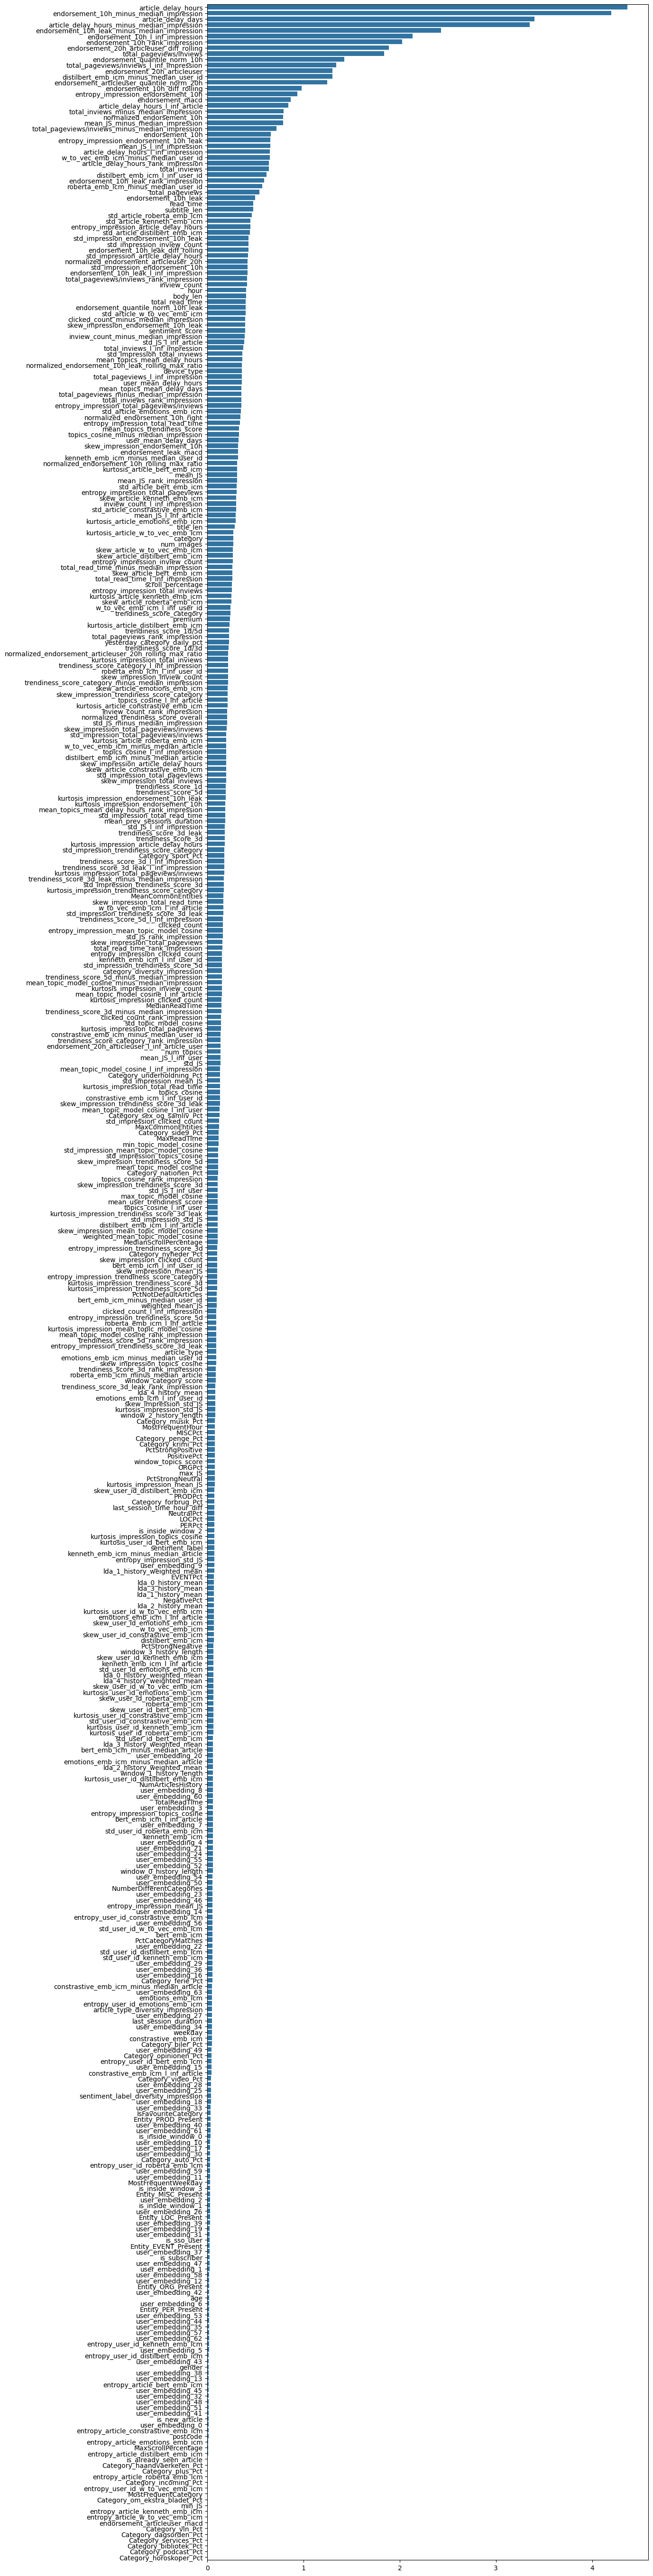

In [16]:
import joblib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

model = joblib.load('/home/ubuntu/tmp_dataset/catboost_rnn_seq_embeddings/model.joblib')

fi = model.feature_importances_
fn = model.feature_names_

sorted_indices = np.argsort(fi)[::-1]

fig, ax = plt.subplots(1, 1, figsize=(12, 70))
sns.barplot(x=fi[sorted_indices], y=np.array(fn)[sorted_indices])